## Import des modules

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('default', category=UserWarning, module='pkg_resources')

In [135]:

bc_after_eda = pd.read_csv("data/bc_after_eda.csv", index_col='Unnamed: 0',dtype={'NumberofFloors':float})
select_columns = ['LargestPropertyUseTypeGFA', 'ListOfAllPropertyUseTypes', 'SecondLargestPropertyUseTypeGFA', 'FirstUseType', 'SecondLargestPropertyUseType', 'YearBuilt', 'NumberofFloors', 'NumberofBuildings','Latitude', 'Longitude', 'Neighborhood',
                                     'SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)','SiteEUI(kBtu/sf)','SumLargestGFA']
bc_after_eda = bc_after_eda[select_columns]
bc_after_eda

,LargestPropertyUseTypeGFA,ListOfAllPropertyUseTypes,SecondLargestPropertyUseTypeGFA,FirstUseType,SecondLargestPropertyUseType,YearBuilt,NumberofFloors,NumberofBuildings,Latitude,Longitude,Neighborhood,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEUI(kBtu/sf),SumLargestGFA
0,88434.0,Hotel,0.0,Hotel,NaN,1927,12.0,1.0,47.61220,-122.33799,DOWNTOWN,7.226362e+06,3.946027e+06,1.276453e+06,2003882.00,81.699997,88434.0
1,83880.0,"Hotel, Parking, Restaurant",15064.0,Hotel,Parking,1996,11.0,1.0,47.61317,-122.33393,DOWNTOWN,8.387933e+06,3.242851e+06,5.145082e+06,0.00,94.800003,103566.0
2,756493.0,Hotel,0.0,Hotel,NaN,1969,41.0,1.0,47.61393,-122.33810,DOWNTOWN,7.258702e+07,4.952666e+07,1.493800e+06,21566554.00,96.000000,756493.0
3,61320.0,Hotel,0.0,Hotel,NaN,1926,10.0,1.0,47.61412,-122.33664,DOWNTOWN,6.794584e+06,2.768924e+06,1.811213e+06,2214446.25,110.800003,61320.0
4,123445.0,"Hotel, Parking, Swimming Pool",68009.0,Hotel,Parking,1980,18.0,1.0,47.61375,-122.34047,DOWNTOWN,1.417261e+07,5.368607e+06,8.803998e+06,0.00,114.800003,191454.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,12294.0,Office,0.0,Office,NaN,1990,1.0,1.0,47.56722,-122.31154,GREATER DUWAMISH,8.497457e+05,5.242709e+05,3.254750e+05,0.00,69.099998,12294.0
3372,16000.0,Other - Recreation,0.0,Other,NaN,2004,1.0,1.0,47.59625,-122.32283,DOWNTOWN,9.502762e+05,3.965461e+05,5.537300e+05,0.00,59.400002,16000.0
3373,7583.0,"Fitness Center/Health Club/Gym, Other - Recrea...",5574.0,Other,Fitness Center/Health Club/Gym,1974,1.0,1.0,47.63644,-122.35784,MAGNOLIA / QUEEN ANNE,5.765898e+06,1.792159e+06,3.973739e+06,0.00,438.200012,13157.0
3374,6601.0,"Fitness Center/Health Club/Gym, Food Service, ...",6501.0,Mixed Use Property,Fitness Center/Health Club/Gym,1989,1.0,1.0,47.52832,-122.32431,GREATER DUWAMISH,7.194712e+05,3.488702e+05,3.706010e+05,0.00,51.000000,13586.0


## Import des modules 

In [136]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import r2_score, mean_absolute_error , root_mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,FunctionTransformer

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


## Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

#### Modes énergétiques

In [137]:
bc_after_eda['UseGas'] = (bc_after_eda['NaturalGas(kBtu)'].notna()) & (bc_after_eda['NaturalGas(kBtu)'] != 0)
bc_after_eda['UseSteam'] = (bc_after_eda['SteamUse(kBtu)'].notna()) & (bc_after_eda['SteamUse(kBtu)'] != 0)
bc_after_eda['UseElectricity'] = (bc_after_eda['Electricity(kBtu)'].notna()) & (bc_after_eda['Electricity(kBtu)'] != 0)


#### distance du centre ville

In [138]:
def haversine(lat1, lon1, lat2, lon2):
    # Entrées: Series -> conversion séparée
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    R = 3958.8
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [139]:
seattle_lat, seattle_lon = 47.6085965, -122.5049456

bc_after_eda['CityDistance'] = haversine(
    bc_after_eda['Latitude'], bc_after_eda['Longitude'],
    seattle_lat, seattle_lon
).round(2)
bc_after_eda['CityDistance'].describe()

count    1630.000000
mean        8.663564
std         1.414665
min         4.960000
25%         7.800000
50%         8.360000
75%         9.430000
max        15.200000
Name: CityDistance, dtype: float64

#### Utilisation multiple

In [140]:
bc_after_eda['MultipleUseType'] = bc_after_eda['ListOfAllPropertyUseTypes'].str.count('s')+1
bc_after_eda['MultipleUseType'].value_counts()

MultipleUseType
1    967
2    530
3     93
4     32
6      3
7      2
5      2
8      1
Name: count, dtype: int64

In [141]:
bc_after_eda.columns

Index(['LargestPropertyUseTypeGFA', 'ListOfAllPropertyUseTypes',
       'SecondLargestPropertyUseTypeGFA', 'FirstUseType',
       'SecondLargestPropertyUseType', 'YearBuilt', 'NumberofFloors',
       'NumberofBuildings', 'Latitude', 'Longitude', 'Neighborhood',
       'SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'SteamUse(kBtu)', 'SiteEUI(kBtu/sf)', 'SumLargestGFA', 'UseGas',
       'UseSteam', 'UseElectricity', 'CityDistance', 'MultipleUseType'],
      dtype='object')

## Split train/test

In [142]:
#predict_values = ['LargestPropertyUseTypeGFA', 'FirstUseType','SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'MultipleUseType', 'UseSteam', 'UseGas',
predict_values = [ 'FirstUseType','SecondLargestPropertyUseType', 'SumLargestGFA', 'MultipleUseType', 'UseSteam', 'UseGas',
       'NumberofFloors', 'NumberofBuildings', 'CityDistance', 'Neighborhood','YearBuilt']
X = bc_after_eda[predict_values]
target = 'SiteEnergyUse(kBtu)'
y = bc_after_eda[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
print("Index X_train avant pipeline :", X_train.index.equals(y_train.index))


Index X_train avant pipeline : True


## Finalisation des features

In [144]:
# ========================
# ÉTAPE 1: PREPROCESSING PERSONNALISÉ 
# ========================

from ocde_p6.preprocessing.transformer import fix_floors_and_discretize

# ========================
# ÉTAPE 2: PIPELINE COMPLET
# ========================

# Colonnes après votre preprocessing
categorical_features = ['FirstUseType', 'SecondLargestPropertyUseType', 'PropertySize' ,
                       'Neighborhood','AgeCategory','EnergyEra','HeightCategory']  # Ajoutez vos autres catégories ici


numerical_features = ['AgeProperty','SumLargestGFA', 'CityDistance', 
                      'MultipleUseType', 'NumberofFloors','NumberofBuildings']

# Pipeline complet
full_pipeline = Pipeline([
    # Étape 1: Preprocessing personnalisé
    ('preprocessing', FunctionTransformer(fix_floors_and_discretize, validate=False)),
    
    # Étape 2: Encodage + Normalisation
    ('encoder', ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features),
        ('num', StandardScaler(), numerical_features)
    ], remainder='passthrough'))
])

# ========================
# ÉTAPE 3: APPLICATION 
# ========================

# Fit sur train et transform train/test
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# ========================
# ÉTAPE 4: CRÉER  DataFrames _final
# ========================

# Récupérer les noms des colonnes
onehot = full_pipeline.named_steps['encoder'].named_transformers_['cat']
onehot_names = onehot.get_feature_names_out(categorical_features)
num_names = [f"scaled_{col}" for col in numerical_features]

# Colonnes restantes (passthrough)
all_cols_after_preprocessing = fix_floors_and_discretize(X_train).columns
remaining_cols = [col for col in all_cols_after_preprocessing 
                 if col not in categorical_features + numerical_features]

# Noms finaux
final_feature_names = list(onehot_names) + num_names + remaining_cols

# Vos DataFrames finaux
X_train_final = pd.DataFrame(X_train_transformed, columns=final_feature_names,index=X_train.index )
X_test_final = pd.DataFrame(X_test_transformed, columns=final_feature_names,index=X_test.index)

# Conversion en numérique
for col in X_train_final.columns:
    X_train_final[col] = pd.to_numeric(X_train_final[col], errors='coerce')
    X_test_final[col] = pd.to_numeric(X_test_final[col], errors='coerce')


print(f"✅ Pipeline terminé!")
print(f"Shape finale: Train {X_train_final.shape}, Test {X_test_final.shape}")


✅ Pipeline terminé!
Shape finale: Train (1304, 118), Test (326, 118)


In [145]:
print("Index X_train_final après pipeline :", X_train_final.index.equals(y_train.index))

Index X_train_final après pipeline : True


In [146]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1304 entries, 1161 to 1972
Columns: 118 entries, FirstUseType_Automobile Dealership to UseGas
dtypes: float64(118)
memory usage: 1.2 MB


In [147]:
# CODE COMPARAISON DES MODELES
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
models = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1)
}

scoring = ['neg_root_mean_squared_error','r2','neg_mean_absolute_error','neg_mean_absolute_percentage_error']
cv_results = {}

print("=== COMPARAISON MODÈLES AVEC PIPELINE COMPLET ===")
for name, model in models.items():
    # Pipeline complet + modèle final
    full_estimator = Pipeline([
        ('preprocess', full_pipeline.named_steps['preprocessing']),
        ('encode_scale', full_pipeline.named_steps['encoder']),
        ('model', model)
    ])
    scores = cross_validate(full_estimator, X_train, y_train, 
                            cv=5, scoring=scoring, n_jobs=-1)
    cv_results[name] = {
        'RMSE': -scores['test_neg_root_mean_squared_error'].mean(),
        'R2': scores['test_r2'].mean(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'MAPE': -scores['test_neg_mean_absolute_percentage_error'].mean()
    }
    print(f"{name} → R²: {cv_results[name]['R2']:.3f}, RMSE: {cv_results[name]['RMSE']:.2f}, MAE: {cv_results[name]['MAE']:.2f}, MAPE: {cv_results[name]['MAPE']:.4f}")
    
    

=== COMPARAISON MODÈLES AVEC PIPELINE COMPLET ===


/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/yves/.c

DummyRegressor → R²: -0.013, RMSE: 27670561.81, MAE: 9705686.63, MAPE: 4.6943


/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/yves/.cache/pypoetry/virtualenvs/ocde-p6-qTWNOnCB-py3.13/lib/python3.13/site-packages/pydantic/_internal/_config.py:383: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


LinearRegression → R²: 0.329, RMSE: 16701534.24, MAE: 6014475.49, MAPE: 1.8407
SVR → R²: -0.077, RMSE: 28311429.92, MAE: 7422038.81, MAPE: 1.2279
GradientBoosting → R²: 0.364, RMSE: 21421178.64, MAE: 4689265.15, MAPE: 0.9864
RandomForest → R²: 0.317, RMSE: 22027042.98, MAE: 4697750.91, MAPE: 0.8009


### Sauvegarde du meilleur résultat

=== COMPARAISON MODÈLES AVEC PIPELINE COMPLET ===  
Filtrage Low target à 1,5% (129020 kbtu)  
+PropertySize  
DummyRegressor → R²: -0.013, RMSE: 27670561.81, MAE: 9705686.63, MAPE: 4.6943  
LinearRegression → R²: 0.329, RMSE: 16701534.24, MAE: 6014475.49, MAPE: 1.8407  
SVR → R²: -0.077, RMSE: 28311429.92, MAE: 7422038.81, MAPE: 1.2279  
GradientBoosting → R²: 0.364, RMSE: 21421178.64, MAE: 4689265.15, MAPE: 0.9864  
RandomForest → R²: 0.317, RMSE: 22027042.98, MAE: 4697750.91, MAPE: 0.8009  

In [148]:
choice= "MAPE"
if choice == "R2":
    best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x][choice])
else:
    best_model_name = min(cv_results.keys(), key=lambda x: cv_results[x][choice])
print(f"\n🏆 Meilleur modèle selon {choice}: {best_model_name}")


🏆 Meilleur modèle selon MAPE: RandomForest


## Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [149]:
# Supposons best_model_name défini précédemment
#best_model_name = "RandomForest"
def optimize_model(df_X_train,df_y_train, df_X_test, df_y_test):
    print(f"=== OPTIMISATION de {best_model_name} ===")

    if best_model_name == 'RandomForest':
        estimator = RandomForestRegressor(random_state=42, n_jobs=-1)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

    elif best_model_name == 'GradientBoosting':
        estimator = GradientBoostingRegressor(random_state=42)
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }

    elif best_model_name == 'LinearRegression':
        estimator = LinearRegression()
        param_grid = {
            'fit_intercept': [True, False],
            'positive': [False, True]
        }

    elif best_model_name == 'SVR':
        estimator = SVR()
        param_grid = {
            'kernel': ['rbf', 'linear', 'poly'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }

    else:
        raise ValueError(f"Modèle non supporté : {best_model_name}")

    # Lancer GridSearchCV
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    gs.fit(df_X_train, df_y_train)

    print("Meilleurs paramètres :", gs.best_params_)
    print("Meilleur score CV (RMSE) :", -gs.best_score_)

    # Évaluation finale
    final_model = gs.best_estimator_
    df_y_pred = final_model.predict(df_X_test)

    print("\n=== PERFORMANCE FINALE sur TEST ===")
    print(f"RMSE: {root_mean_squared_error(df_y_test, df_y_pred):.0f}")
    print(f"R²: {r2_score(df_y_test, df_y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(df_y_test, df_y_pred):.0f}")
    print(f"MAPE: {mean_absolute_percentage_error(df_y_test, df_y_pred):.4f}")
    return gs
gs = optimize_model(X_train_final,y_train,X_test_final,y_test)

=== OPTIMISATION de RandomForest ===
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Meilleur score CV (RMSE) : 21903972.41049627

=== PERFORMANCE FINALE sur TEST ===
RMSE: 11580682
R²: 0.7701
MAE: 3728348
MAPE: 0.6973


### Sauvegarde du meilleur résultat  

=== OPTIMISATION de RandomForest ===  
Filtrage Low target à 1,5% (129020 kbtu)  
+PropertySize
Fitting 5 folds for each of 81 candidates, totalling 405 fits  
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}  
Meilleur score CV (RMSE) : 21903972.41049627  
  
=== PERFORMANCE FINALE sur TEST ===  
RMSE: 11580682  
R²: 0.7701  
MAE: 3728348  
MAPE: 0.6973  

In [150]:
best_model = gs.best_estimator_

if best_model_name in ['GradientBoosting','RandomForest']:

    importances = best_model.feature_importances_
    feature_names = X_train_final.columns

    # Affichage du top 15 features les plus importantes
    sorted_idx = importances.argsort()[::-1]
    print("Top 30 features by importance:")
    for idx in sorted_idx[:50]:
        print(f"- {feature_names[idx]}: {importances[idx]:.6f}")

Top 30 features by importance:
- scaled_SumLargestGFA: 0.406018
- scaled_NumberofBuildings: 0.373452
- FirstUseType_Data Center: 0.051649
- FirstUseType_Hospital: 0.038655
- SecondLargestPropertyUseType_Laboratory: 0.028378
- scaled_CityDistance: 0.023311
- Neighborhood_NORTHEAST: 0.015176
- FirstUseType_Mixed Use Property: 0.011753
- SecondLargestPropertyUseType_Office: 0.007249
- FirstUseType_Other: 0.005863
- scaled_AgeProperty: 0.005633
- scaled_NumberofFloors: 0.005014
- FirstUseType_Laboratory: 0.004180
- Neighborhood_EAST: 0.003986
- SecondLargestPropertyUseType_Data Center: 0.002216
- FirstUseType_University: 0.001987
- FirstUseType_Supermarket / Grocery Store: 0.001699
- FirstUseType_Large Office: 0.001651
- FirstUseType_Hotel: 0.001268
- UseSteam: 0.001248
- scaled_MultipleUseType: 0.000894
- FirstUseType_Medical Office: 0.000665
- Neighborhood_SOUTHWEST: 0.000649
- SecondLargestPropertyUseType_Other - Services: 0.000590
- Neighborhood_DELRIDGE: 0.000577
- FirstUseType_Wareho

## Colonnes à supprimer

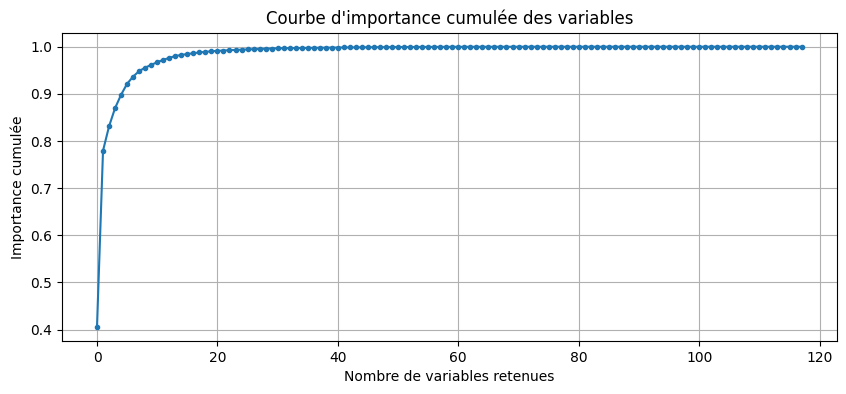

In [151]:
# Supposons model est un RandomForest entraîné
sorted_importances = pd.Series(best_model.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)

# Cumul
cumul = sorted_importances.cumsum()

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(cumul)), cumul, marker='.')
plt.xlabel('Nombre de variables retenues')
plt.ylabel('Importance cumulée')
plt.title('Courbe d\'importance cumulée des variables')
plt.grid(True)
plt.show()


In [152]:
seuil_importance = sorted_importances[cumul <= 0.998].min()
# Variables à conserver
print(f"Seuil calculé {seuil_importance:.6f}")
selected_features = sorted_importances[sorted_importances >= seuil_importance].index
non_selected_features = [col for col in X_train_final.columns if col not in selected_features]
print(f"{len(selected_features)} variables conservées :")
print("\n".join(selected_features.tolist()))

Seuil calculé 0.000150
38 variables conservées :
scaled_SumLargestGFA
scaled_NumberofBuildings
FirstUseType_Data Center
FirstUseType_Hospital
SecondLargestPropertyUseType_Laboratory
scaled_CityDistance
Neighborhood_NORTHEAST
FirstUseType_Mixed Use Property
SecondLargestPropertyUseType_Office
FirstUseType_Other
scaled_AgeProperty
scaled_NumberofFloors
FirstUseType_Laboratory
Neighborhood_EAST
SecondLargestPropertyUseType_Data Center
FirstUseType_University
FirstUseType_Supermarket / Grocery Store
FirstUseType_Large Office
FirstUseType_Hotel
UseSteam
scaled_MultipleUseType
FirstUseType_Medical Office
Neighborhood_SOUTHWEST
SecondLargestPropertyUseType_Other - Services
Neighborhood_DELRIDGE
FirstUseType_Warehouse
SecondLargestPropertyUseType_nan
SecondLargestPropertyUseType_Parking
Neighborhood_LAKE UNION
UseGas
Neighborhood_NORTHWEST
Neighborhood_GREATER DUWAMISH
AgeCategory_Récent
FirstUseType_Senior Care Community
SecondLargestPropertyUseType_Restaurant
FirstUseType_Refrigerated Wareho

In [153]:
print(f"{len(non_selected_features)} variables supprimées :")
print("\n".join(non_selected_features))

80 variables supprimées :
FirstUseType_Automobile Dealership
FirstUseType_Bank Branch
FirstUseType_Courthouse
FirstUseType_Distribution Center
FirstUseType_Financial Office
FirstUseType_Fire Station
FirstUseType_Fitness Center/Health Club/Gym
FirstUseType_Food Service
FirstUseType_K-12 School
FirstUseType_Library
FirstUseType_Lifestyle Center
FirstUseType_Manufacturing/Industrial Plant
FirstUseType_Movie Theater
FirstUseType_Museum
FirstUseType_Office
FirstUseType_Parking
FirstUseType_Performing Arts
FirstUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)
FirstUseType_Police Station
FirstUseType_Pre-school/Daycare
FirstUseType_Prison/Incarceration
FirstUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)
FirstUseType_Residential Care Facility
FirstUseType_Restaurant
FirstUseType_Retail Store
FirstUseType_Self-Storage Facility
FirstUseType_Small- and Mid-Sized Office
FirstUseType_Social/Meeting Hall
FirstUseType_Strip Mall
FirstUseType_Worship Facility
SecondLargestProperty

In [154]:
X_train_reduced = X_train_final.drop(columns=non_selected_features).copy()
X_test_reduced = X_test_final.drop(columns=non_selected_features).copy()
gs = optimize_model(X_train_reduced,y_train,X_test_reduced,y_test)
final_model = gs.best_estimator_

=== OPTIMISATION de RandomForest ===
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs paramètres : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Meilleur score CV (RMSE) : 21900770.7359063

=== PERFORMANCE FINALE sur TEST ===
RMSE: 11474486
R²: 0.7743
MAE: 3675939
MAPE: 0.6976


### Sauvegarde du meilleur résultat
=== OPTIMISATION de RandomForest ===  
Filtrage Low target à 1,5% (129020 kbtu)  et features > 0.998   
+PropertySize  
Meilleurs paramètres : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}  
Meilleur score CV (RMSE) : 21900770.7359063  
  
=== PERFORMANCE FINALE sur TEST ===  
RMSE: 11474486  
R²: 0.7743  
MAE: 3675939  
MAPE: 0.6976  

In [155]:
# Reconstruire le pipeline COMPLET (preprocessing + encoding + modèle final)
complete_pipeline = Pipeline([
    ('preprocessing', full_pipeline.named_steps['preprocessing']),
    ('encoder', full_pipeline.named_steps['encoder']),
    ('model', final_model)
])

# FIT le pipeline complet sur les données BRUTES (X_train, pas X_train_reduced)
# Cela permettra au pipeline de "mémoriser" toutes les transformations
complete_pipeline.fit(X_train, y_train)

# Vérifier que le pipeline fonctionne
assert hasattr(complete_pipeline, "predict")
y_pred_test = complete_pipeline.predict(X_test)
print(f"Test RMSE: {root_mean_squared_error(y_test, y_pred_test):.0f}")

Test RMSE: 11498919


In [156]:
X_demo = {
      "FirstUseType": "Hotel",
      "SecondLargestPropertyUseType": None,
      "MultipleUseType": 1,
      "SumLargestGFA": 88434.0,
      "UseSteam": True,
      "UseGas": False,
      "NumberofFloors": 12.0,
      "NumberofBuildings": 1.0,
      "CityDistance": 8.5,
      "Neighborhood": "DOWNTOWN",
      "YearBuilt": 1999
    }
df_demo = pd.DataFrame([X_demo])
y_demo = complete_pipeline.predict(df_demo)[0]
print(round(y_demo))

7548090


# Sauvegarde BentoML

In [157]:
import bentoml
bentoml.sklearn.save_model(
    name="building_energy_rf_pipeline",
    model=complete_pipeline,
    signatures={"predict": {"batchable": True}},
    metadata={
        "author": "day811",
        "n_features": len(X_train_reduced.columns),
        "feature_names": list(X_train_reduced.columns)
    },
    
)

Model(tag="building_energy_rf_pipeline:sub4yivmewnvilhq", path="/tmp/bentoml-model-building_energy_rf_pipeline-nz626_qm")